In [ ]:
# Jiwon Lee JIL303@pitt.edu

In [1]:
import pandas as pd
import numpy as np
import re
from pysam import FastaFile
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
pd.set_option('display.max_columns', None)
orfs = pd.read_csv('orfcoord_refmt.txt', sep='\t')

In [3]:
orfs ##this is the file format

,orf_name,chr,strand,exon_starts,exon_stops,orf_starts,orf_stops
0,c16riboseqorf141,chr16,+,89716582;89717344,89716637;89717386,89716582,89717386
1,c16riboseqorf142,chr16,+,89716634,89716891,89716634,89716891
2,c16riboseqorf143,chr16,+,89717451,89718032,89717451,89718032
3,c16norep142,chr16,+,89716888;89717344,89716904;89717386,89716888,89717386
4,c16riboseqorf143_noTR,chr16,+,89717451,89717828,89717451,89717828


In [4]:
genome_path = '/net/dali/home/carvunis/jil303/human_riboseq/misc_data/Homo_sapiens.GRCh38.dna.primary_assembly_chr.fa'
ff=FastaFile(genome_path) 

In [5]:
comp = {"a":"t", "t":"a", "c":"g", "g":"c"}

def complement(seq):
    return ''.join(comp.get(base, base) for base in seq)

def rc(seq):
    return complement(seq[::-1])

def extract_ranges(row):
    start_list = [int(x) - 1 for x in row["exon_starts"].split(";")] ## deduct 1 for easy string query with fastafile
    end_list = list(map(int, row["exon_stops"].split(";")))
    return list(zip(start_list, end_list))

##wig files are 1-based -> deduct 1 from pos for easy processing / 0-based ranges; deduct 1 from value to account for iRibo bug
def read_wig_to_dataframe(file_path):
    data, chrom = [], None
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('track'):
                continue
            if line.startswith('variableStep'):
                chrom = line.split('chrom=')[1].strip()
#                if chrom != 'chr1':
#                    break
            else:
                pos, value = map(int, line.split())
                data.append((chrom, pos - 1, value - 1))
    return pd.DataFrame(data, columns=['chr', 'position', 'value'])

In [6]:
##set up dataframe
pd.set_option('display.max_columns', None)
orfs.loc[:,"ranges"] = orfs.apply(extract_ranges, axis=1)

In [7]:
##read in wigs
base_dir='/net/dali/home/carvunis/jil303/human_riboseq/20240221_run/transcriptome_candorfs/'
wig_f = read_wig_to_dataframe(base_dir + 'riboseq_reads_plus.wig')
wig_r = read_wig_to_dataframe(base_dir + 'riboseq_reads_minus.wig')

In [8]:
def filter_wig_dat(chrom,strand,ranges):
    dat = wig_f if strand == '+' else wig_r
    dat = dat[dat['chr']==chrom]
    filtered_df = dat[pd.concat([(dat["position"].between(start, end-1)) for start, end in ranges], axis=1).any(axis=1)]
    return filtered_df

def orf_indices_from_ranges(ranges, strand):
    orf_positions = [pos for start, stop in ranges for pos in (range(start, stop) if strand == '+' 
                                                               else reversed(range(start, stop)))]
    return orf_positions

def subset_wig_rf(wig_file, ranges, strand, rf=0): #0,1,2
    orf_positions = orf_indices_from_ranges(ranges, strand)
    if strand == '-':
        orf_positions.reverse()
    first_codon_positions = {pos for i, pos in enumerate(orf_positions) if i % 3 == rf}
    return wig_file[wig_file["position"].isin(first_codon_positions)]



In [9]:
from scipy.stats import binom_test

def calc_binom_test(read_array):
    p=1/3
    frame0=0
    frame_sum=0
    for i in range(0, len(read_array), 3):
        no_tie=False
        cur_reads = read_array[i:i+3]
        if cur_reads[0] > cur_reads[1] and cur_reads[0] > cur_reads[2]:
            frame0+=1
            no_tie=True
        elif cur_reads[1] > cur_reads[0] and cur_reads[1] > cur_reads[2]:
            no_tie=True
        elif cur_reads[2] > cur_reads[1] and cur_reads[2] > cur_reads[0]:
            no_tie=True
        if no_tie:
            frame_sum+=1
    result = binom_test(frame0, frame_sum, p, alternative='greater')
    return result

def format_scientific_notation(number):
    # Format number to scientific notation with 2 decimal places
    formatted_number = f"{number:.2e}"
    
    # Map exponent to superscript characters
    base, exponent = formatted_number.split('e')
    
    # Remove the leading zero from the exponent if it exists (but keep the minus sign)
    if exponent.startswith('-'):
        exponent = '-' + exponent[1:].lstrip('0')
    else:
        exponent = exponent.lstrip('0')
    
    # Map digits and minus sign to superscript
    superscript_map = str.maketrans({
        '0': '⁰', '1': '¹', '2': '²', '3': '³', '4': '⁴',
        '5': '⁵', '6': '⁶', '7': '⁷', '8': '⁸', '9': '⁹', '-': '⁻'
    })
    
    # Convert exponent part to superscript
    exponent = exponent.translate(superscript_map)
    
    # Combine the base and superscript exponent
    return f"{base} x 10{exponent}"



In [18]:
def create_riboseq_plot(cur_orf, combined_reads, rf_0_sum, rf_1_sum, rf_2_sum, pval, log_scale=False):
    plt.figure(figsize=(7, 3), dpi=300)
    print(pval)

    colors = ['blue', 'yellow', 'red']
    bar_colors = [colors[i % len(colors)] for i in range(len(combined_reads))]
    plt.bar(x=np.array(range(len(combined_reads))), height=np.array(combined_reads),color=bar_colors)

    custom_labels = [rf_0_sum, rf_1_sum, rf_2_sum]
    custom_handles = [Patch(color=color, label=label) for color, label in zip(colors, custom_labels)]

    # Adding the custom legend
    plt.legend(handles=custom_handles, title='Ribo-seq Read Count', 
               loc='upper right', bbox_to_anchor=(0.99, 0.99),
#               bbox_to_anchor=(1.05, 1), loc='upper left', 
               title_fontsize=9, fontsize=9, framealpha=0.5,
            markerscale=0.6,  # Make the markers (e.g., bars) smaller
           labelspacing=0.5,  # Reduce space between labels
           handlelength=0.8
              )  # Adjust the length of the handles (bars)
    
    if log_scale:
        plt.yscale('log')
        plt.ylabel('Number of reads (log-scaled)')
    else:
        plt.ylabel('Number of reads')
    
    plt.xlabel('Position along ORF')


    # Adding the title with smaller font size
    plt.title('Ribo-seq reads along ' + cur_orf, fontsize=13)
    
    #plt.suptitle('Binomial p-val: ' + str(round(pval, 2)), fontsize=8)
    plt.text(0.22, 0.90, 'Binomial p-val: ' + pval, ha='center', va='center', 
             fontsize=10, transform=plt.gca().transAxes)

    plt.savefig('riboseq_plot_' + cur_orf + '.svg', format='svg')
#plt.show()

In [19]:
def run_riboseq_plot(orfs_df, index, log_scale=False):
    # Get ORF info
    cur_orf = orfs_df['orf_name'].iloc[index]
    chrom = orfs_df['chr'].iloc[index]
    ranges = orfs_df['ranges'].iloc[index]
    strand = orfs_df['strand'].iloc[index]
    
    wig_dat = filter_wig_dat(chrom, strand, ranges)
    orf_positions = [pos for start, stop in ranges
                     for pos in (range(start, stop) if strand == '+' 
                                 else reversed(range(start, stop)))]
    
    # Get RF sums
    rf_0 = subset_wig_rf(wig_dat, ranges, strand)
    rf_1 = subset_wig_rf(wig_dat, ranges, strand, rf=1)
    rf_2 = subset_wig_rf(wig_dat, ranges, strand, rf=2)
    
    rf_0_sum = sum(rf_0.value)
    rf_1_sum = sum(rf_1.value)
    rf_2_sum = sum(rf_2.value)
    
    wig_dat2 = wig_dat.set_index('position')
    
    # Create combined reads (aligned with ORF positions)
    combined_reads = pd.Series(orf_positions).map(wig_dat2['value']).fillna(0).tolist()
    combined_reads = [int(x) for x in combined_reads]
    
    # Calculate p-value
    pval = format_scientific_notation(calc_binom_test(combined_reads))
    # Plot the results
    create_riboseq_plot(cur_orf, combined_reads, rf_0_sum, rf_1_sum, rf_2_sum, pval, log_scale)

3.90 x 10⁻⁶


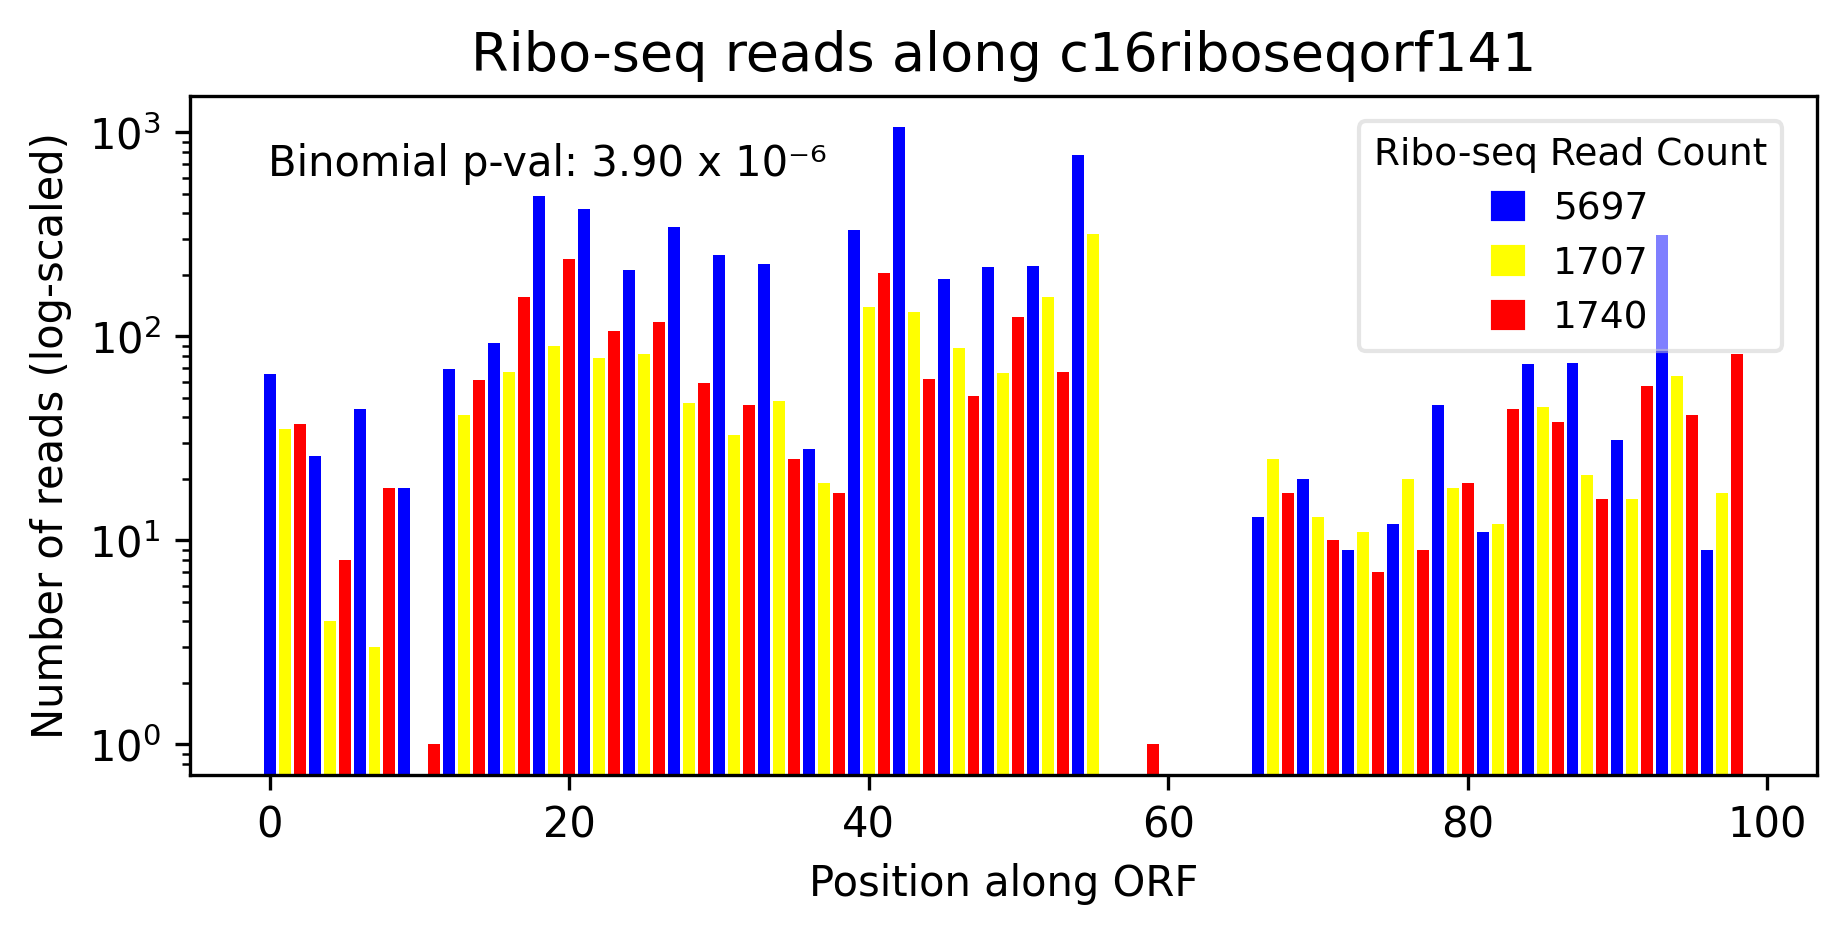

In [22]:
run_riboseq_plot(orfs, 0, log_scale=True)

3.93 x 10⁻¹⁶


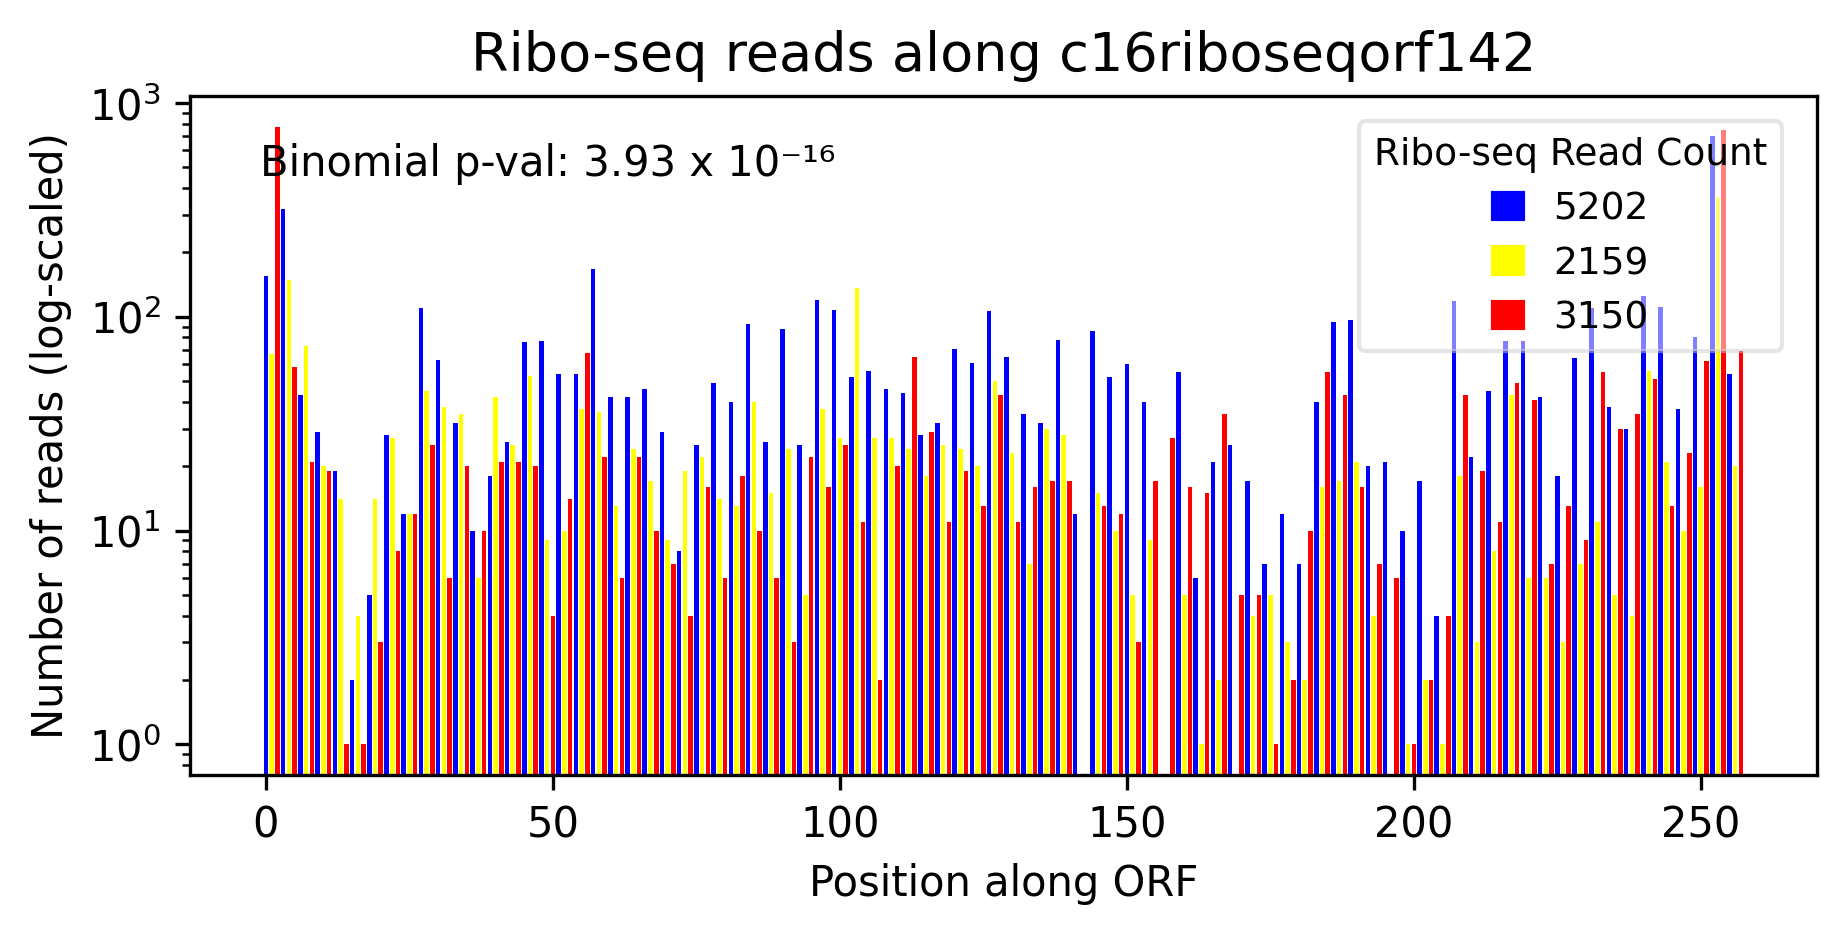

In [23]:
run_riboseq_plot(orfs, 1, log_scale=True)

7.53 x 10⁻⁴¹


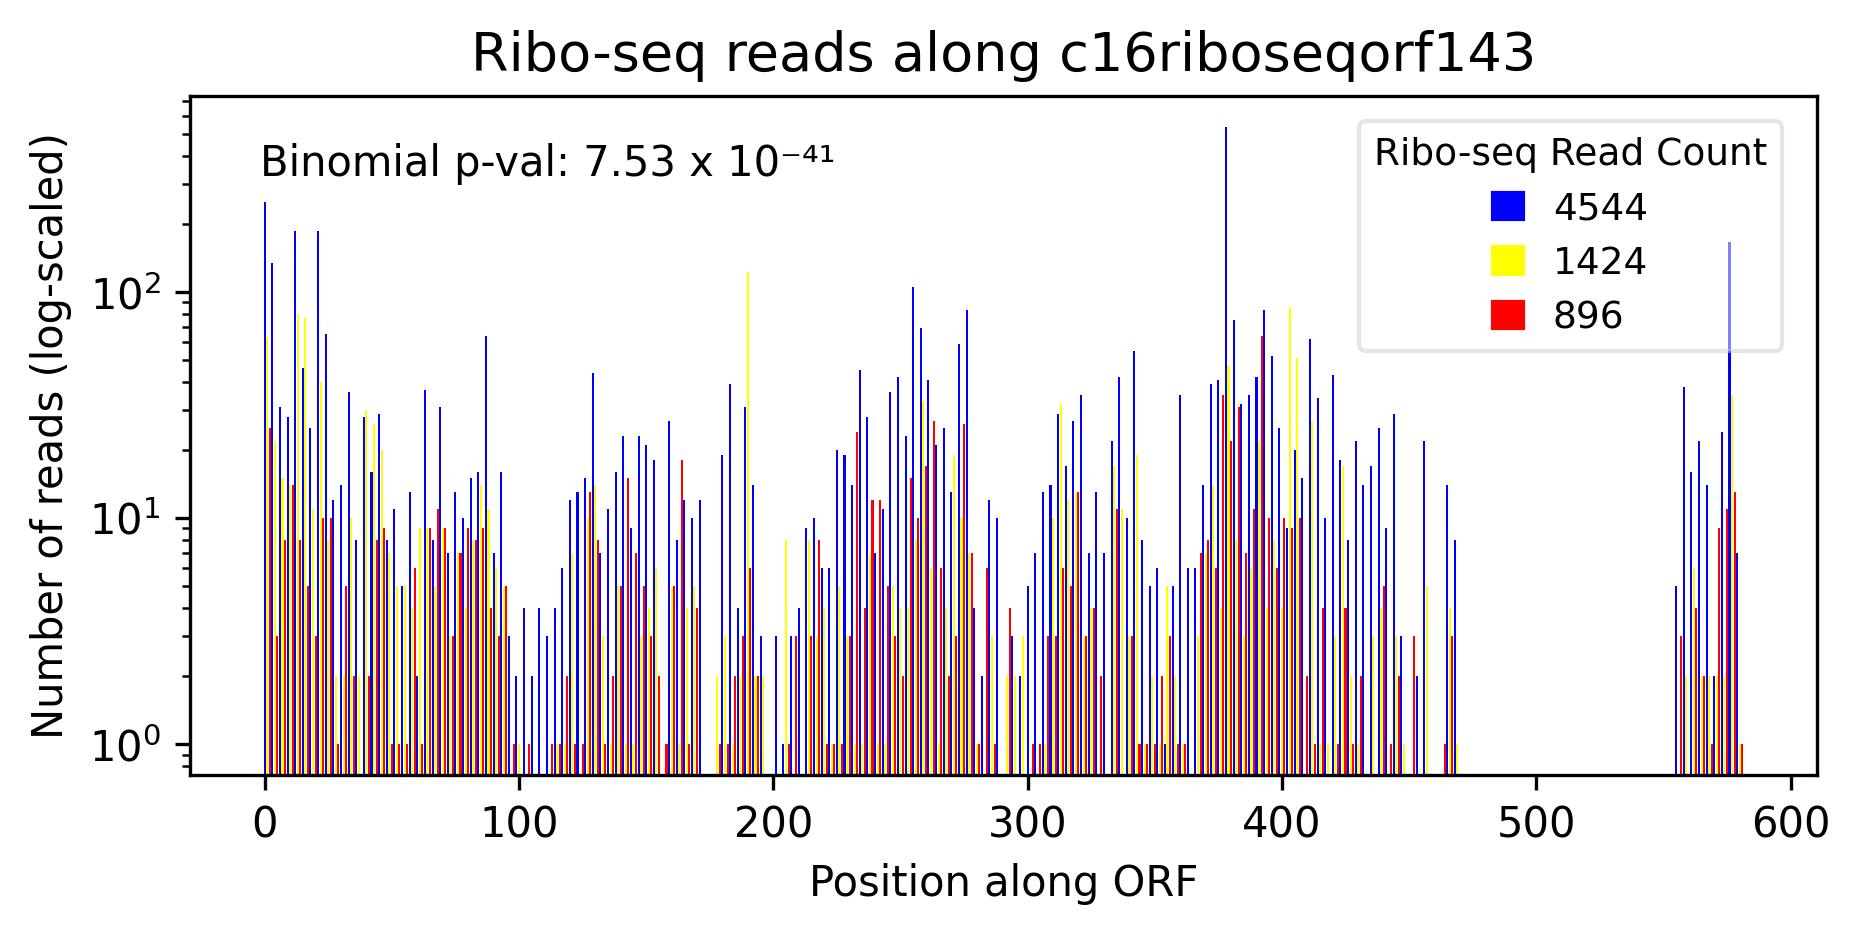

In [24]:
run_riboseq_plot(orfs, 2, log_scale=True)

1.44 x 10⁻²


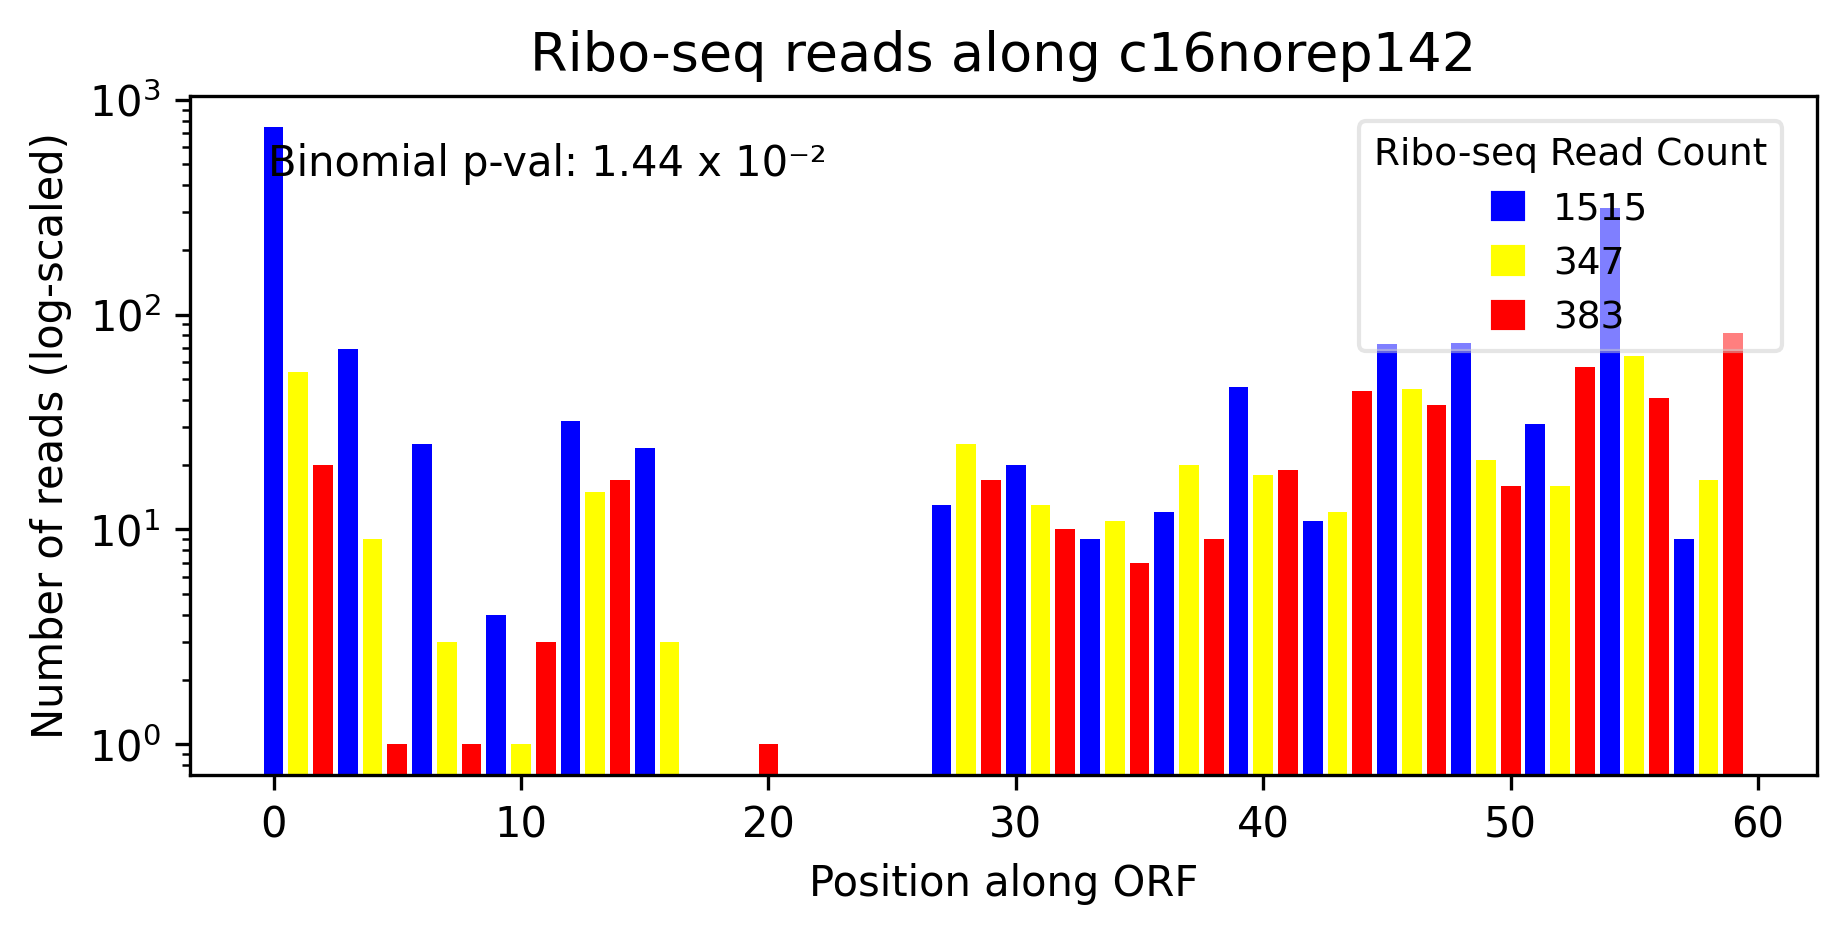

In [25]:
run_riboseq_plot(orfs, 3, log_scale=True)

2.92 x 10⁻³¹


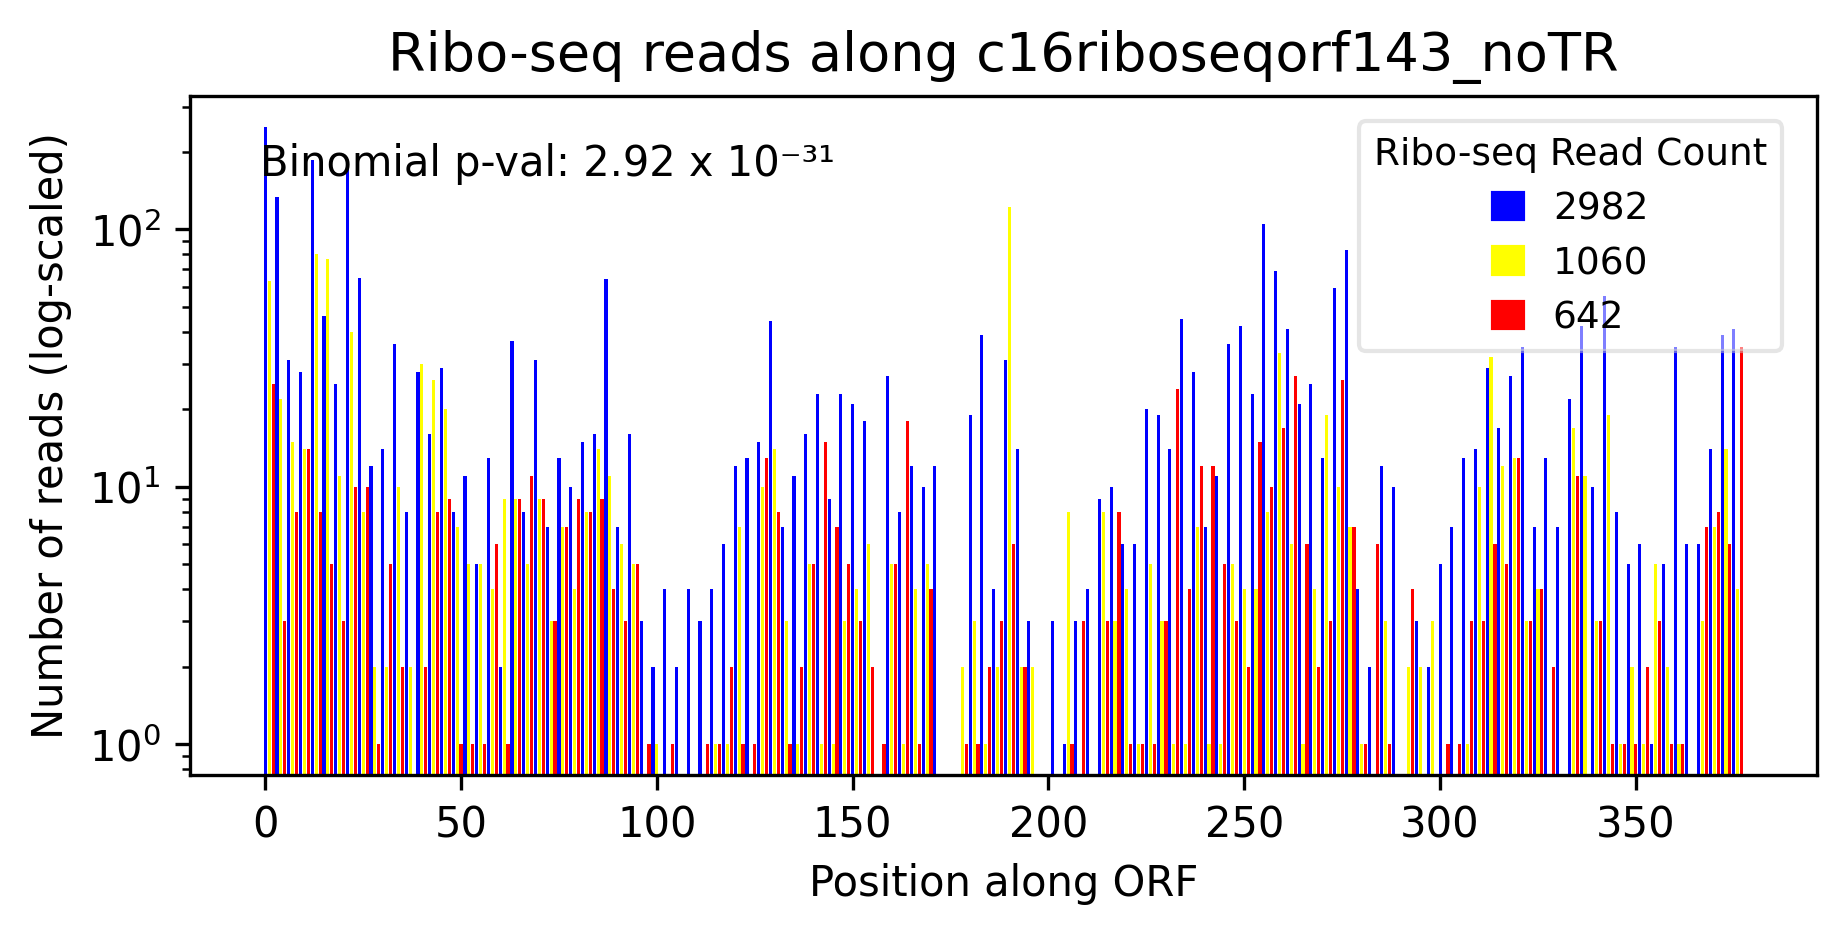

In [26]:
run_riboseq_plot(orfs, 4, log_scale=True)